# Extract and Visualize Gradient Attribution

In [1]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm
from datasets import load_from_disk
import torch

from IPython.display import HTML

from captum.attr import Saliency, IntegratedGradients
from captum.attr import visualization as viz

score_to_predict = 'vocabulary'

## Data

In [2]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_inputs(example):
    return tokenizer(example['text'], truncation=True, return_tensors='pt')

ds = load_from_disk('../data/ellipse.hf/test').map(tokenize_inputs, remove_columns=['text'])

Loading cached processed dataset at /home/jovyan/active-projects/ellipse-methods-showcase/data/ellipse.hf/test/cache-4be22a2c846c3238.arrow


## Model

In [3]:
model = AutoModelForSequenceClassification.from_pretrained(f'../bin/{score_to_predict.lower()}-model/').cuda()
model.eval()
print()

### A note on BERT's tokenization scheme

In [4]:
for token_type, token_str in tokenizer.special_tokens_map.items():
    print(f'{token_type: <10}: {token_str: <6} | {tokenizer.encode(token_str, add_special_tokens=False)[0]:>3}')

unk_token : [UNK]  | 100
sep_token : [SEP]  | 102
pad_token : [PAD]  |   0
cls_token : [CLS]  | 101
mask_token: [MASK] | 103


## Helper Functions

In [5]:
def forward_func(input_embedding, attention_mask=None):
    return model(inputs_embeds=input_embedding,
                 attention_mask=attention_mask).logits

In [6]:
def construct_whole_bert_embeddings(input_ids):
    input_embeddings = model.bert.embeddings(input_ids)    
    return input_embeddings

In [7]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [8]:
def visualize_text(datarecords, attribution_record_name):
    print('\033[1m', 'Visualizations', '\033[0m')

    dom = ['<table width: 100%>']

    rows = [
        '<tr><th>Text ID</th>'
        '<th>Word Importance</th>'
        '<th>True Score</th>'
        '<th>Predicted Score</th>'
        '<th>Approximation Error</th></tr>'
    ]
    
    for datarecord in datarecords:
        rows.append(
            ''.join(
                [
                    '<tr>',
                    '<td>{}</td>'.format(datarecord['text_id']),
                    viz.format_word_importances(
                        datarecord['tokens'], datarecord[attribution_record_name]
                    ),
                    viz.format_classname(datarecord['true_score']),
                    viz.format_classname(datarecord['pred_score']),
                    viz.format_classname(datarecord['delta']),
                    '</tr>',
                ]
            )
        )

    dom.append(
        '<div style="border-top: 1px solid; margin-top: 5px; \
        padding-top: 5px; display: inline-block">'
    )
    dom.append('<b>Legend: </b>')

    for value, label in zip([-1, 0, 1], ['Negative', 'Neutral', 'Positive']):
        dom.append(
            '<span style="display: inline-block; width: 10px; height: 10px; \
            border: 1px solid; background-color: \
            {value}"></span> {label}  '.format(
                value=viz._get_color(value), label=label
            )
        )
    dom.append('</div>')

    dom.append(''.join(rows))
    dom.append('</table>')
    html = HTML(''.join(dom))
    display(html)

## Input Saliency

In [9]:
# Captum function for calculating saliency attributions
saliency = Saliency(forward_func)
ig = IntegratedGradients(forward_func)

# Container for VisualizationDataRecords
viz_records = []

for sample in tqdm(ds.shuffle().select(range(3))):
    
    # We will use this dict to store information necessary to visualize saliency
    viz_dict = {}
    
    # Get the actual score
    viz_dict['true_score'] = round(sample.pop(score_to_predict.capitalize()), 2)  
    
    # Get the text identifier in case we see something interesting
    viz_dict['text_id'] = sample.pop('text_id')
    
    # Push tensors to GPU
    sample = {k: torch.tensor(v).cuda() for k, v in sample.items()}

    # We need to create the embeddings manually so we can track their gradients
    manual_embed = construct_whole_bert_embeddings(sample['input_ids'])

    # Get the plain text version of the tokens (but leave them separated by spaces)
    viz_dict['tokens'] = tokenizer.convert_ids_to_tokens(sample['input_ids'][0].detach().tolist())

    # Calculate the predicted score separately, because the Saliency module does not output it.
    with torch.no_grad():    
        pred = forward_func(manual_embed)[0]
        viz_dict['pred_score'] = round(pred.item(), 2)
    
    # Use Saliency module to track gradients across a forward pass
    saliency_attribution = saliency.attribute(inputs=manual_embed, abs=False)
    
    # We can also use an approach called integrated gradients
    # We establish a baseline to compare against, like an input that is all zeroes.
    # Here, I create a tensor of the same length as the input but made up
    # entirely of [MASK] tokens. Different baselines are possible.
    baseline = [101]
    baseline.extend([103] * (len(sample['input_ids'][0]) - 2))
    baseline.append(102)

    baseline = construct_whole_bert_embeddings(
        torch.tensor([baseline], dtype=int).cuda()
    )

    ig_attributions, approximation_error = ig.attribute(
        inputs=manual_embed,
        baselines=(baseline),
        return_convergence_delta=True)
    
    viz_dict['saliency'] = summarize_attributions(saliency_attribution)
    
    viz_dict['integrated'] = summarize_attributions(ig_attributions)
    viz_dict['delta'] = round(approximation_error.item(), 2)

    viz_records.append(viz_dict)
    
visualize_text(viz_records, 'integrated')

  0%|          | 0/10 [00:00<?, ?it/s]

 Visualizations 


## Publication-ready Visualizations

In [118]:
# Visualization
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None} #display figures the same way they will be saved.
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import transforms
from mpl_toolkits import axes_grid1

class TextHeatmap:
    """
    Optionally prints a dispersion map and matplotlib colorbar.
    ---
    tokens: list of strings
    attributions: list of importance scores, same length as tokens
    width: inches
    """
    def __init__(self,
                 tokens,
                 attributions,
                 width=7.5,
                 fontsize=12,
                 fontname='DejaVu Sans Mono',
                 dpi=300,
                 disp_colorbar=False,
                 disp_dispersion=False):
        
        self.tokens = tokens
        self.attributions = attributions
        self.figsize_x = width
        self.fontsize = fontsize
        self.fontname = fontname
        self.colormap = mpl.cm.RdBu
        self.norm = mpl.colors.Normalize(vmin=-1, vmax=1)
        self.dpi = dpi
        self.disp_colorbar = disp_colorbar
        self.disp_dispersion = disp_dispersion
        self.text_w = 0.85 * width * self.dpi # 85% of width
        
    def _draw_token(self, token):
        self.text = self.ax.text(0.01,
                                 1,
                                 token,
                                 transform=self.trans,
                                 fontname=self.fontname,
                                 fontsize=self.fontsize,
                                 bbox=self.bbox)
        
        self.text.draw(self.artist)
        self.ex = self.text.get_window_extent()
        self.trans = transforms.offset_copy(
            self.text.get_transform(),
            x = self.ex.width + self.fontsize,
            units='dots')
    
    def display(self, title=None, savefile=None):
        self.fig = plt.figure(figsize=(self.figsize_x, 5), dpi=self.dpi, facecolor='None')
        if title is not None:
            self.fig.suptitle(title, fontsize=self.fontsize + 2)

        # self.ax = self.fig.add_axes([0, 0, .9, .95])
        self.ax = self.fig.add_subplot()
        self.ax.set_axis_off()
        self.divider = axes_grid1.make_axes_locatable(self.ax)

        self.y = 0 # where to start drawing words
        self.ex = None
        self.trans = self.ax.transData
        self.artist = self.ax.figure.canvas.get_renderer()

        # Draw words
        for token, attribution in zip(self.tokens, self.attributions):
            self.bbox={
                'facecolor': self.colormap(self.norm(attribution)),
                'alpha': 0.6,
                'edgecolor': 'white',
                'pad': 1,
                'snap': True
            }
            self._draw_token(token)

            # remove text outside of text_w
            # redraw on next line
            if self.ex.x1 > self.text_w:
                self.text.remove() 
                self.y -= self.ex.height + self.fontsize
                self.trans = transforms.offset_copy(
                    self.ax.transData,
                    y=self.y,
                    units='dots')
                self._draw_token(token)

        self.y -= self.ex.height*4 + self.fontsize
        self.text_h = (abs(self.y)) / self.dpi

        if self.disp_dispersion:
            self.fig.set_figheight(self.text_h + 1)
            self.disp_bar = self.divider.append_axes("bottom", size=.8, pad=0)
            self.disp_bar.set_axis_off()
            self.img = np.array(self.attributions).reshape(1, -1)
            cax = self.disp_bar.inset_axes([0.01, 0.5, .95, .3], transform=self.disp_bar.transAxes)
            cax.pcolor(self.img,
                       cmap=self.colormap.with_extremes(under='None'),
                       vmin=0,
                       vmax=1,
                       edgecolors='k',
                       linewidths=.1)
            cax.get_yaxis().set_visible(False)
            cax.set_xlabel(f'Tokens (N={len(self.attributions)})')
        else:
            self.fig.set_figheight(self.text_h)

        if self.disp_colorbar:
            self.cax = self.divider.append_axes('right', size=.10, pad=0)
            self.fig.colorbar(mpl.cm.ScalarMappable(norm=self.norm, cmap=self.colormap),
                              cax=self.cax,
                              ticks=[-1, 0, 1],
                              alpha=.5)
            
        if savefile is None:
            plt.show()
        else:
            plt.savefig(savefile)
        plt.close()

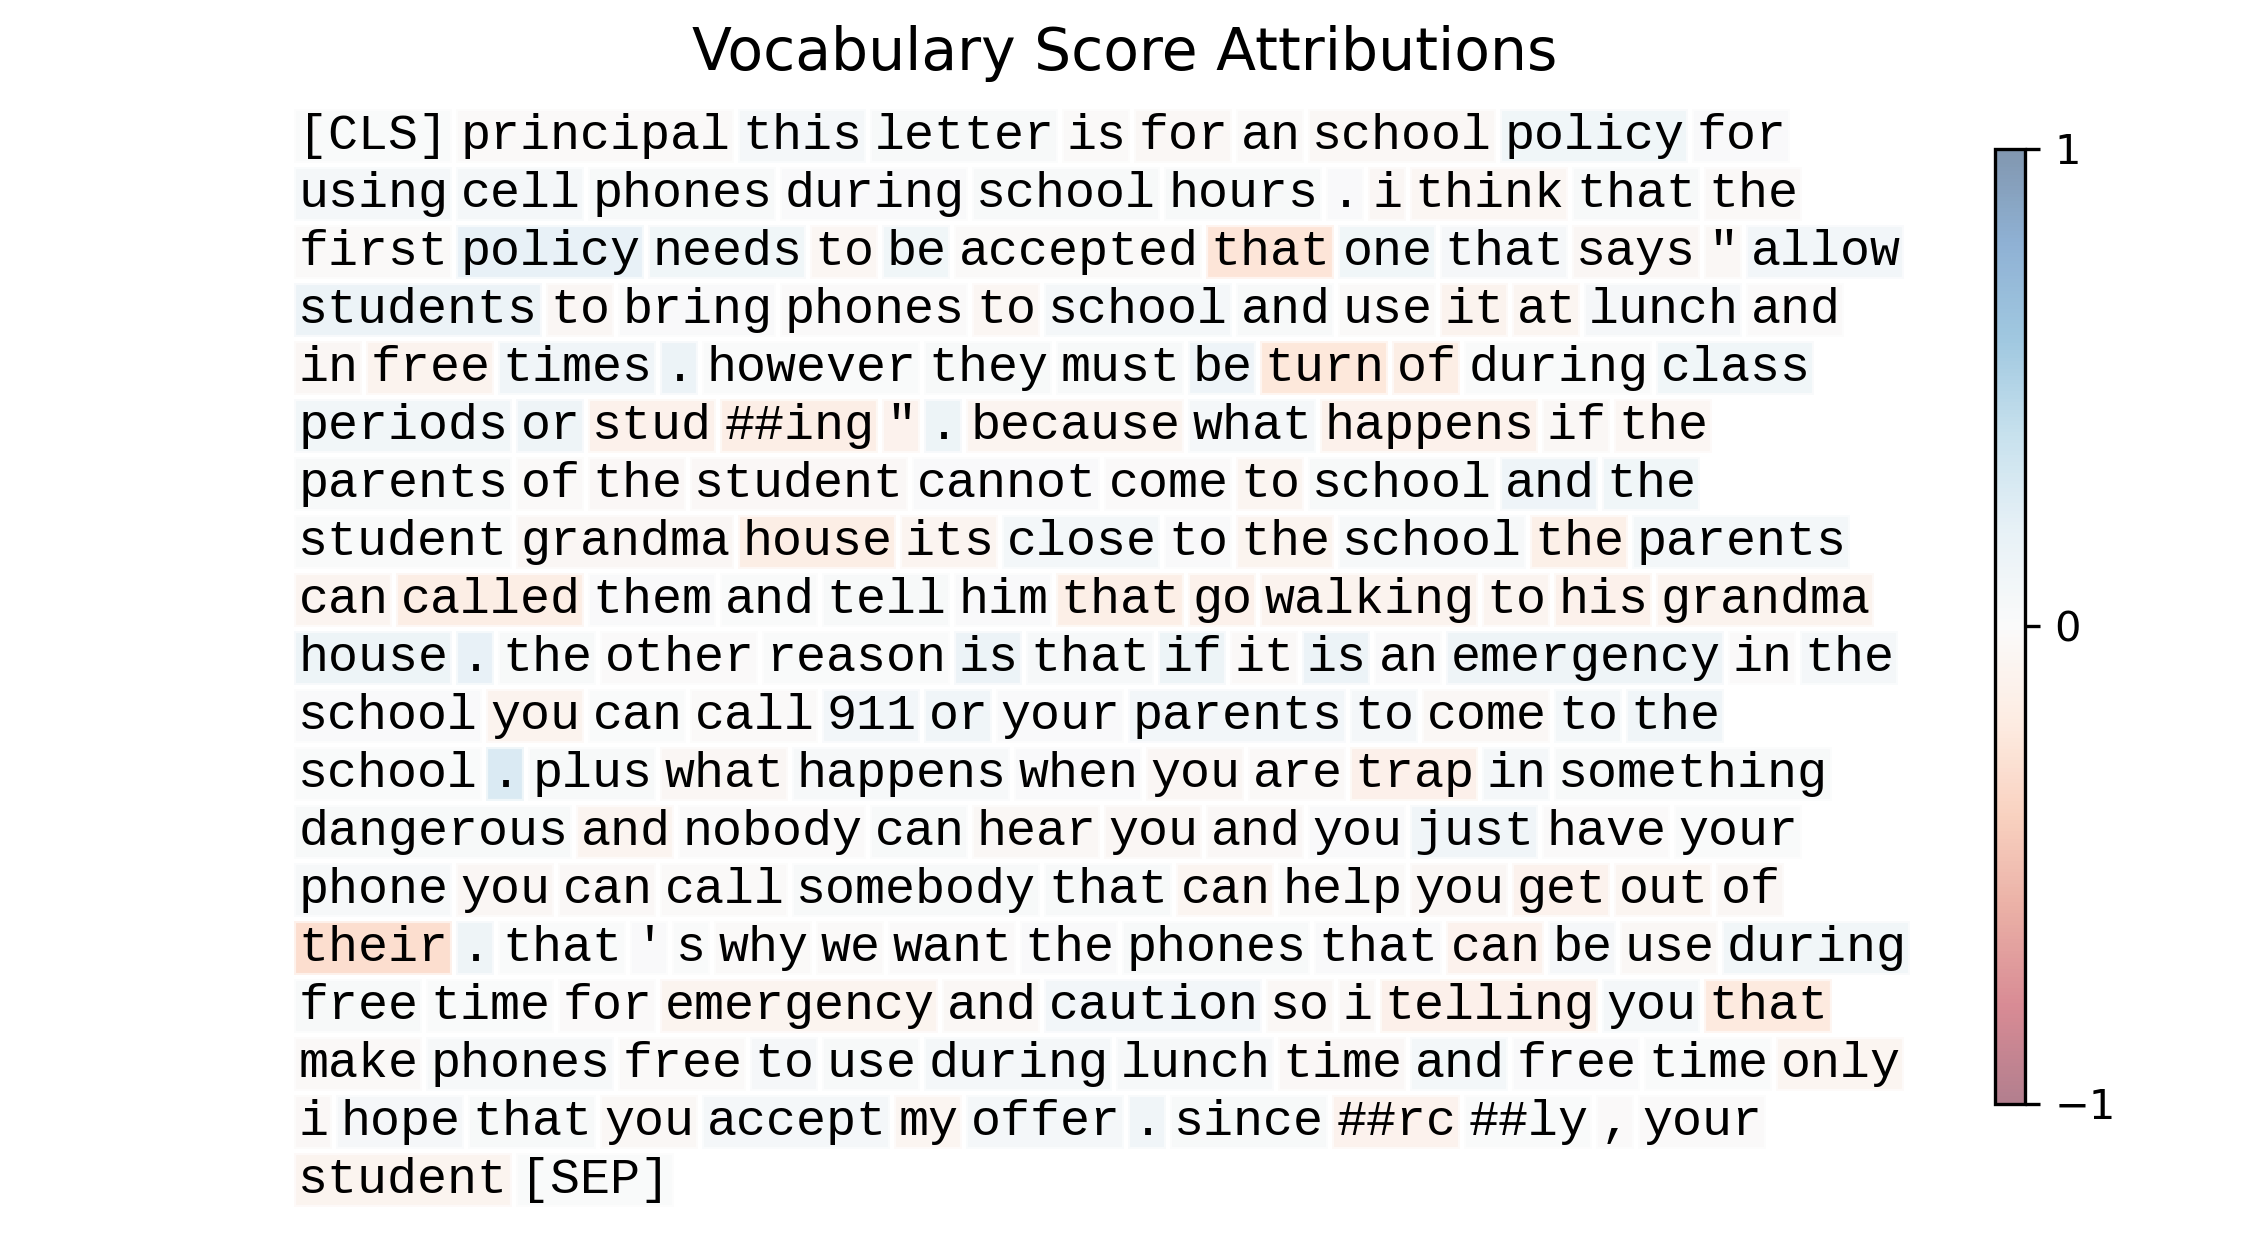

In [117]:
tokens = viz_records[0]['tokens']
attributions = viz_records[0]['integrated'].detach().cpu().numpy()
# mpl.font_manager.get_font_names()
TextHeatmap(tokens, attributions, fontname='Liberation Mono', disp_colorbar=True).display(title='Vocabulary Score Attributions')